# Research Summary: Predicting Protein Thermostability

The goal of this assignment is to develop a model that predicts the ranking of protein thermostability as measured by tm i.e. the melting point,  following single-point amino acid mutations and deletions. Accurate predictions of protein stability are crucial for various biotechnological and pharmaceutical applications.

Dataset Description:

1. Training Set: Includes natural and engineered protein sequences with single or multiple mutations. Given Data has been derived from multiple sources of published studies such as the Meltome atlas and other public datasets. 
    
2. Test Set: Contains experimental melting temperatures for 2413 single-mutation variants of an enzyme (GenBank: KOC15878.1), provided by Novozymes A/S.
    Features:
        1. seq_id: Unique identifier for each protein variant.
        2. protein_sequence: Amino acid sequence of each variant, which determines the protein thermostability.
        3. pH: Acidity level of aqueous under which stability was measured.
        4. data_source: Source of the data.
        5. tm: Experimental melting temperature which is our target variable. Higher tm values signify greater protein thermostability

# Current State-of-the-Art Techniques:

 **Evolutionary Scale Modeling (ESM):**

*        Overview: ESM utilizes transformer-based language models trained on large-scale protein sequences to predict various properties.  
*        Advantage: Captures long-range dependencies and evolutionary information from sequences.
*        Limitation: High computational requirements and limited by the quality and diversity of training data.
*        Source: Rives et al., "Biological structure and function emerge from scaling unsupervised learning to 250 million protein sequences," 2021 
      

 **Rosetta:**

*         Overview: A suite of software tools for protein modeling and analysis, including structure prediction and stability assessment.
*         Advantage: Robust and extensively validated across numerous protein engineering tasks.
*         Limitation: Computationally intensive and requires significant expertise to use effectively.
*         Source: Leaver-Fay et al., "ROSETTA3: an object-oriented software suite for the simulation and design of macromolecules," 2011 .

Limitations of Current Techniques:

1. Computational Resources: There is a High computational cost incurred by training and inference of models like ESM and Rosetta.

2. Data Quality and Diversity: Model Performance is highly dependent on the quality and diversity of the training dataset, which can lead to high bias in models that do not generalize well to novel sequences.

3. Interpretability: Many advanced models, especially DL-based methods, lack interpretability, making it difficult to understand the underlying mechanisms driving predictions.

4. Generalization: Models trained on specific datasets may not generalize well to different types of proteins or experimental conditions, thereby limiting their utility.


Continuous advancements in model architecture, training algorithms, and data curation are of the essence to overcome above mentioned challenges and improve the reliability and utility of protein stability predictions.

In [1]:
# Install the Biopython package, which is useful for biological computations and data analysis
!pip install biopython

# Import necessary libraries for data analysis
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations and array handling
import matplotlib.pyplot as plt  # For creating visualizations
import seaborn as sns  # For statistical data visualization with improved aesthetics
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.preprocessing import StandardScaler  # For feature scaling to standardize data
from sklearn.ensemble import GradientBoostingRegressor  # For implementing gradient boosting regression model
from scipy.stats import spearmanr  # For computing Spearman's rank correlation coefficient
from sklearn.impute import SimpleImputer  # For handling missing data by imputing values
from scipy.stats import pearsonr 
from scipy.stats import entropy #Measure the diversity of amino acids in the sequence.
from Bio.SeqUtils.ProtParam import ProteinAnalysis #Isoelectric Point (pI): The pH at which the protein carries no net electrical charge.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 34.5 MB/s eta 0:00:0000:0100:01


In [2]:
# 1. Data Loading and Preprocessing
def load_and_preprocess_data(train_path, test_path, updates_path=None):
    """Load and preprocess the training and test data."""
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    
    if updates_path:
        train_updates = pd.read_csv(updates_path)
        train_data.update(train_updates)
    
    # Remove outliers based on 'tm' values
    q1 = train_data['tm'].quantile(0.01)
    q3 = train_data['tm'].quantile(0.99)
    train_data = train_data[(train_data['tm'] >= q1) & (train_data['tm'] <= q3)]
    
    return train_data, test_data

In [3]:
#2. Exploratory Data Analysis
def perform_eda(train_data, test_data):
    
    # Plot distribution of the target variable (tm)
    plt.figure(figsize=(10, 6))
    sns.histplot(train_data['tm'], kde=True)
    plt.title('Distribution of Melting Temperature (tm)')
    plt.xlabel('tm')
    plt.ylabel('Count')
    plt.show()

    # Plot relationship between pH and tm
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='pH', y='tm', data=train_data)
    plt.title('Relationship between pH and Melting Temperature')
    plt.xlabel('pH')
    plt.ylabel('tm')
    plt.show()
    
    if train_data['tm'].isnull().any() or train_data['pH'].isnull().any() :
        # We want to Handle missing values by Dropping rows with missing values in pH or tm
        train_data.dropna(subset=['pH', 'tm'], inplace=True)  #Here inplace=True modifies train_data w/o creating a copy

    corr_coef, p_value = pearsonr(train_data['pH'],train_data['tm'])

    print("Pearson correlation coefficient:", corr_coef)     # Pearson correlation coefficient: 0.06, signifies very weak correlation
    print("p-value:", p_value) #pvalue < 0.05 signifies it's statistically significant
    


    # Add sequence length column
    test_data['seq_length'] = test_data['protein_sequence'].apply(len)
    train_data['seq_length'] = train_data['protein_sequence'].apply(len)


    # Plot distribution of sequence lengths
    plt.figure(figsize=(10, 6))
    sns.histplot(train_data['seq_length'], kde=True, label='Train')
    sns.histplot(test_data['seq_length'], kde=True, label='Test')
    plt.title('Distribution of Protein Sequence Lengths')
    plt.xlabel('Sequence Length')
    plt.ylabel('Count')
    plt.legend()
    plt.show()
    
    # Creating a Heatmap of Correlation Matrix
    plt.figure(figsize=(10, 8))
    corr_matrix = train_data[['tm', 'pH', 'seq_length']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix Heatmap')
    plt.show()

    # Creating a Violin Plot of tm by pH (Binning pH values for better visualization)
    bin_edges = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    bin_labels = ['0-1', '1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10', '10-11']
    train_data['pH_bin'] = pd.cut(train_data['pH'], bins=bin_edges, labels=bin_labels)

    plt.figure(figsize=(14, 8))
    sns.violinplot(x='pH_bin', y='tm', data=train_data)
    plt.title('Distribution of Melting Temperature (tm) by pH Bins')
    plt.xlabel('pH Bin')
    plt.ylabel('tm')
    plt.xticks(rotation=45)
    plt.show()
    
    #Creating Pair plots 
    sampled_data = train_data[['tm', 'pH', 'seq_length']].sample(frac=0.1, random_state=42)  # Sampling 10% data for visualization
    sns.pairplot(sampled_data, diag_kind='kde', plot_kws={'alpha':0.3, 's':15})
    plt.suptitle('Pair Plot of Numerical Features (Sampled Data)', y=1.02)
    plt.show()

    

In [4]:
wild_type_sequence = "VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK"

# 2. Feature Engineering
def create_features(data):
    """Create features for the dataset."""
    features = pd.DataFrame()
    features['seq_length'] = data['protein_sequence'].str.len()
    features['pH'] = data['pH']
    
    # Adding amino acid composition features
    aa_list = 'ACDEFGHIKLMNPQRSTVWY'# List of 20 amino acids, which we want to iterate over in protein sequence
    for aa in aa_list:
        features[f'{aa}_ratio'] = data['protein_sequence'].apply(lambda x: x.count(aa) / len(x))
    
    #Charge: calculate the net charge of the sequence by counting positively charged amino acids (R and K) and subtracting the count of negatively charged amino acids (D and E).
    features['charge'] = data['protein_sequence'].apply(lambda x: sum(1 for aa in x if aa in 'RK') - sum(1 for aa in x if aa in 'DE'))
    
    #Hydrophobic Ratio:calculate the ratio of hydrophobic amino acids (A, V, I, L, M, F, Y, W) in the sequence.
    features['hydrophobic_ratio'] = data['protein_sequence'].apply(lambda x: sum(1 for aa in x if aa in 'AVILMFYW') / len(x))
    
    #Shannon Entropy: Measuring the diversity of amino acids in the sequence.
    features['shannon_entropy'] = data['protein_sequence'].apply(lambda x: entropy([x.count(aa) / len(x) for aa in aa_list]))
    
    #Isoelectric Point (pI) is the pH at which the protein carries no net electrical charge.
    features['isoelectric_point'] = data['protein_sequence'].apply(lambda x: ProteinAnalysis(x).isoelectric_point())
    
    # Aromaticity: calculating the ratio of aromatic amino acids (F, W, Y) in the sequence.
    features['aromaticity'] = data['protein_sequence'].apply(lambda x: sum(1 for aa in x if aa in 'FWY') / len(x))
    
    # Aliphatic index measures the relative volume of aliphatic side chains i.e. (A,V,I,L).
    def aliphatic_index(seq):
        return sum([seq.count(aa) for aa in 'AIVL']) / len(seq)
    features['aliphatic_index'] = data['protein_sequence'].apply(aliphatic_index)
    
    # Instability index as certain amino acids and their combinations are associated with protein instability
    features['instability_index'] = data['protein_sequence'].apply(lambda x: ProteinAnalysis(x).instability_index())
    
    # Molecular weight as larger proteins (having more interactions with each other) are generally more thermostable
    features['molecular_weight'] = data['protein_sequence'].apply(lambda x: ProteinAnalysis(x).molecular_weight())
    
    # Computing the difference between engineered sequences and wild-type sequence
    def compare_to_wild_type(seq, wild_type):
        # Ensuring both sequences are the same length by truncating both sequences
        min_len = min(len(seq), len(wild_type))
        seq = seq[:min_len]
        wild_type = wild_type[:min_len]
        
        # Calculating Number of mutations b/w the same length of engineered and wildtype sequence
        num_mutations = sum(1 for a, b in zip(seq, wild_type) if a != b)
        
        # Creating a list of tuples of Position-specific mutations over the entire length of engineered sequence
        mutations = [(i, seq[i], wild_type[i]) for i in range(len(seq)) if seq[i] != wild_type[i]]
        
        return num_mutations, mutations

    # Adding number of mutation to features dataframe
    features['num_mutations'] = data['protein_sequence'].apply(lambda x: compare_to_wild_type(x, wild_type_sequence)[0])
    
    # Adding specific mutation types such as hydrophobic to hydrophilic changes. hydrophobic aa: ('AVILMFYW') & hydrophilic aa: ('DEKR')
    # Using Zip to iterate over corresponding elements from both protein sequence and wild type sequence
    features['num_hydrophobic_to_hydrophilic'] = data['protein_sequence'].apply(
        lambda x: sum(1 for a, b in zip(x, wild_type_sequence[:len(x)]) if a != b and a in 'AVILMFYW' and b in 'DEKR')
    )
    
    return features

In [5]:
# 3. Model Building
def train_model(X, y):
    """Training a Gradient Boosting model."""
    model = GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, 
                                      min_samples_split=5, min_samples_leaf=2, random_state=42)
    model.fit(X, y) 
    return model

# 4. Prediction and Evaluation of tm values
def predict_and_evaluate(model, X, y_true=None):
    """Making predictions and evaluating the model if true values are provided."""
    y_pred = model.predict(X) #using trained model to predict tm values
    if y_true is not None:
        correlation, _ = spearmanr(y_true, y_pred) #Spearman correlation measures the monotonic relationship between true and predicted tm values in distributed data
        print(f"Spearman correlation: {correlation}")
    return y_pred

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


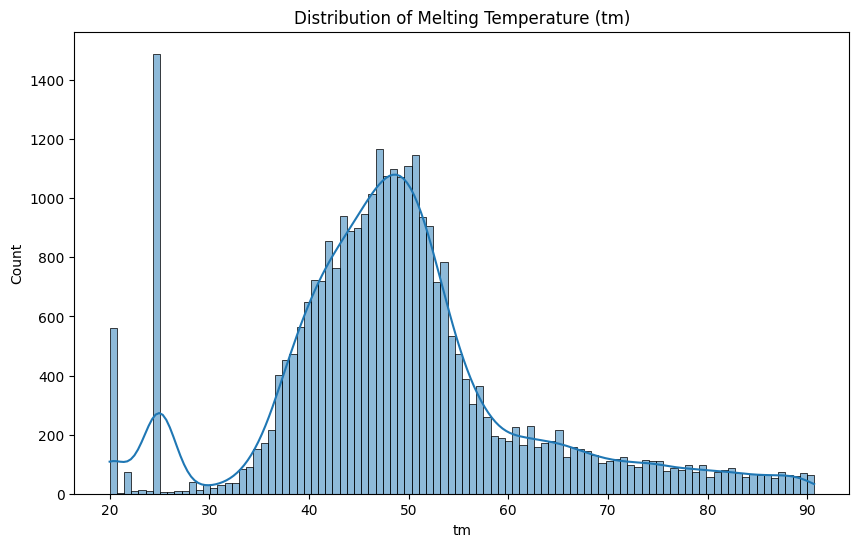

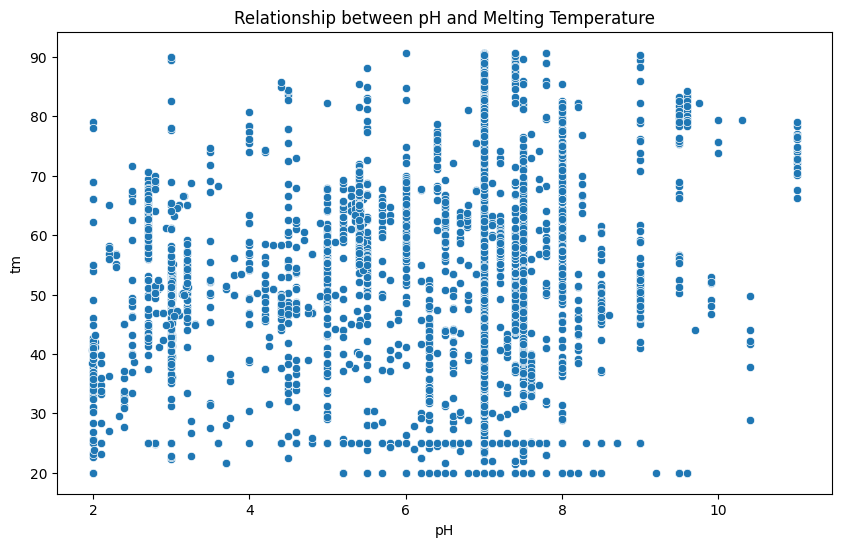

Pearson correlation coefficient: 0.060560490733265845
p-value: 3.1521995531369624e-26


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


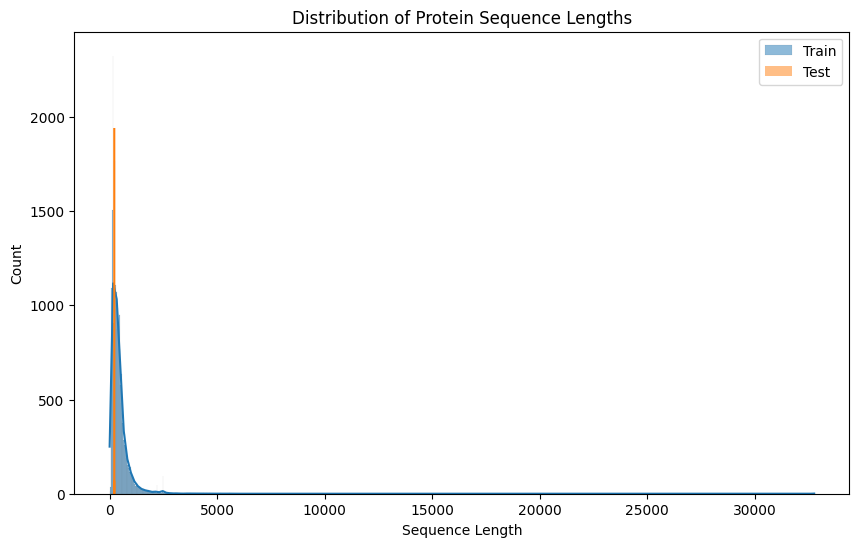

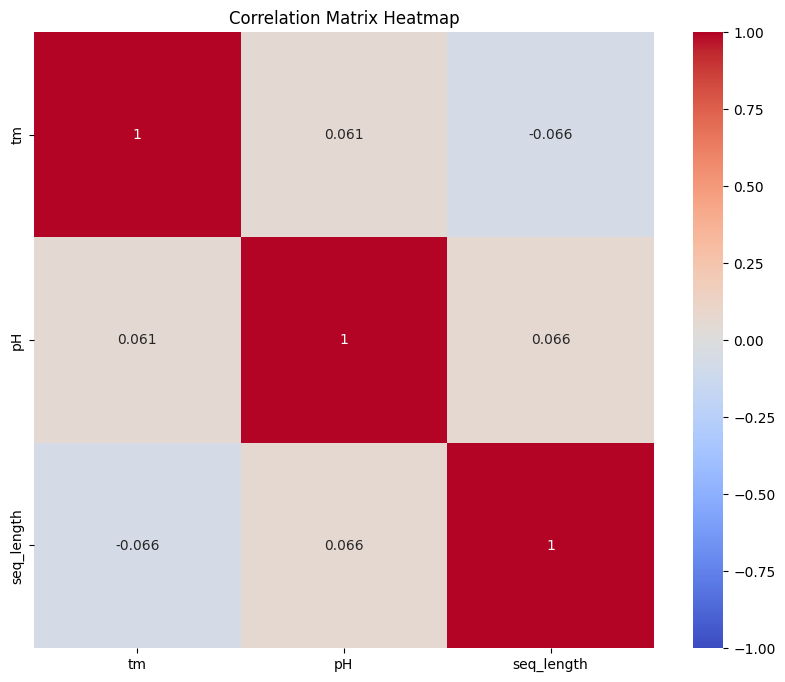

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


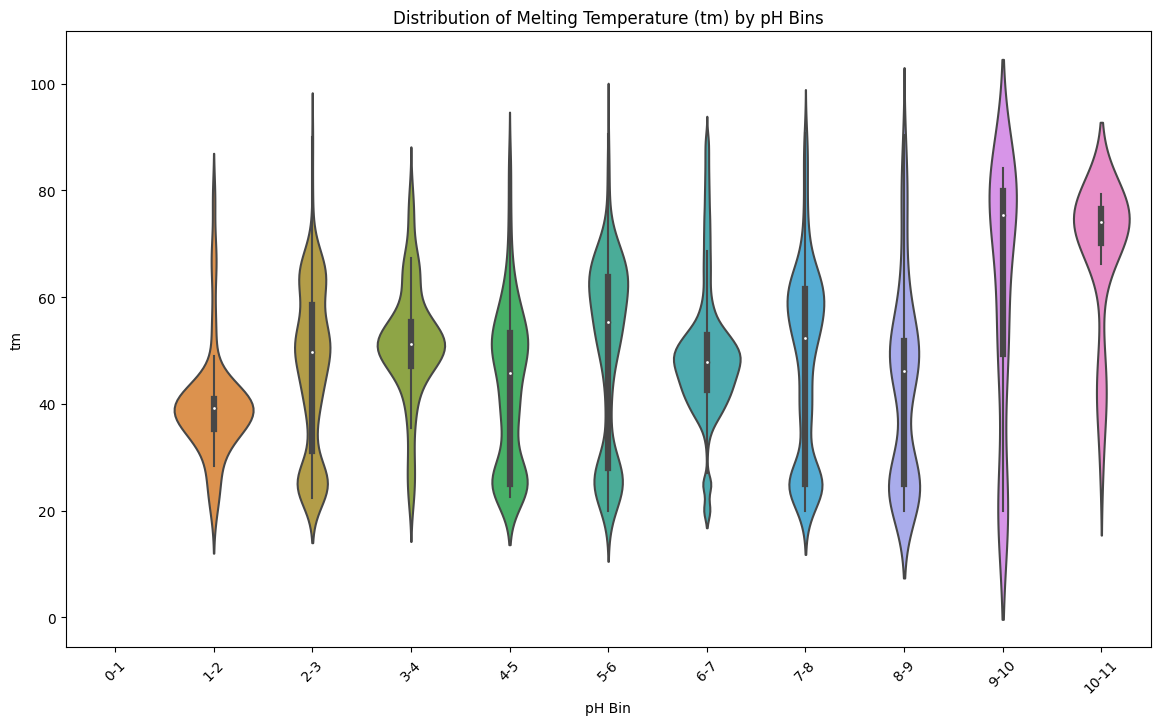

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


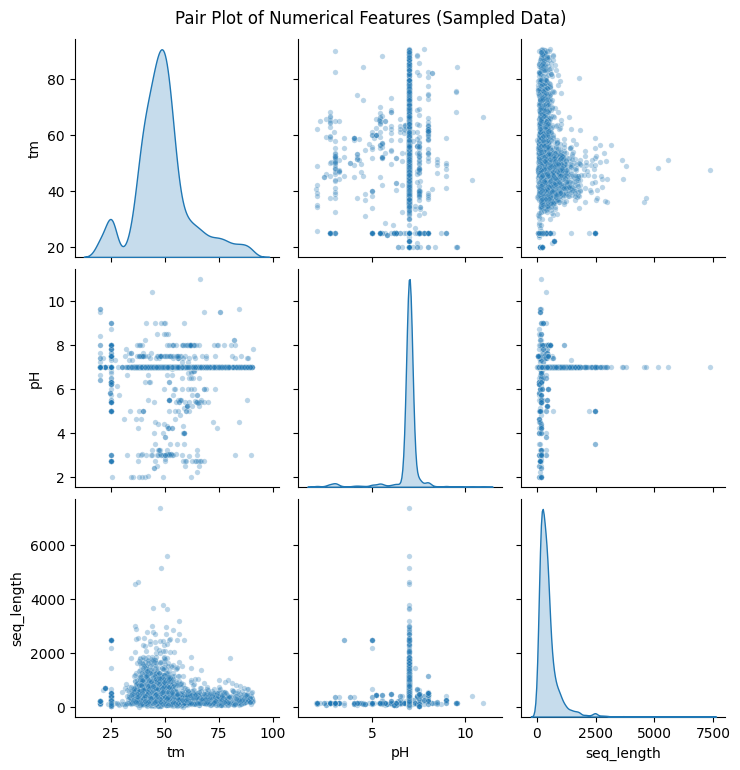

Creating Features
Validation set performance:
Spearman correlation: 0.571013201717597
Submission file created: submission.csv

Top 10 most important features:
              feature  importance
13            N_ratio    0.112077
17            S_ratio    0.107049
1                  pH    0.091638
15            Q_ratio    0.091155
9             I_ratio    0.057705
23  hydrophobic_ratio    0.055850
16            R_ratio    0.049378
10            K_ratio    0.047450
24    shannon_entropy    0.040255
3             C_ratio    0.031716


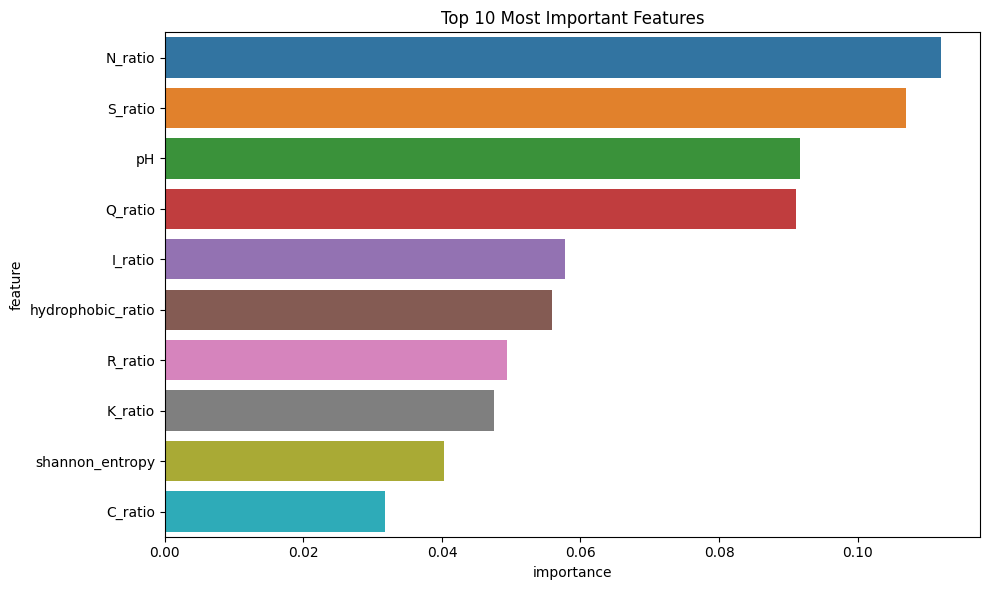

In [6]:
# Main execution
if __name__ == "__main__":
    # 1. Loading and preprocessing data
    train_data, test_data = load_and_preprocess_data('/kaggle/input/training-and-testing-dataset/train.csv', 
                                                     '/kaggle/input/training-and-testing-dataset/test.csv', 
                                                     '/kaggle/input/training-and-testing-dataset/train_updates_20220929.csv')
    
    
    # 2. Performing EDA
    perform_eda(train_data, test_data)
    
    # 3. Feature engineering for training and testing datasets
    print("Creating Features")
    train_features = create_features(train_data)
    test_features = create_features(test_data)
    
    # 4. Handling missing values by imputing missing values with the mean value in each column 
    imputer_object = SimpleImputer(strategy='mean')
    train_features = pd.DataFrame(imputer_object.fit_transform(train_features), columns=train_features.columns) #fits the imputer object to the training data & then transforms the training features
    test_features = pd.DataFrame(imputer_object.transform(test_features), columns=test_features.columns) #Imputes missing values in test data using the previously learned imputer object
    
    # 5. Randomly splitting a dataset into training and testing sets. Random_State ensures reproducibility
    X_train, X_val, y_train, y_val = train_test_split(train_features, train_data['tm'], test_size=0.2, random_state=42)
    
    # 6. Scaling features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train) #calculate mean and std of each feature and apply transformation to the training data.
    X_val_scaled = scaler.transform(X_val) #apply same scaling parameters calculated above to the validation data
    X_test_scaled = scaler.transform(test_features) #apply same scaling parameters calculated above to the test data
    
    # 7. Train model
    model = train_model(X_train_scaled, y_train)
    
    # 8. Evaluating model on validation set
    print("Validation set performance:")
    val_predictions = predict_and_evaluate(model, X_val_scaled, y_val)
    
    # 9. Predicting on test set
    test_predictions = predict_and_evaluate(model, X_test_scaled)
    
    # 10. Creating a submission file
    submission = pd.DataFrame({
        'seq_id': test_data['seq_id'],
        'tm': test_predictions
    })
    submission.to_csv('submission.csv', index=False)
    print("Submission file created: submission.csv")

    # 11. Ranking of Features according to decreasing order of importance and plotting them
    feature_importance = pd.DataFrame({
        'feature': train_features.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 most important features:")
    print(feature_importance.head(10))
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
    plt.title('Top 10 Most Important Features')
    plt.tight_layout()
    plt.show()